## ***Reinforcement Learning - 2024***

Stefano Aragoni, Carol Arévalo, José González, Luis Santos

-----------

### *Proyecto Final*

Este proyecto implementa un agente de refuerzo que simula un dispositivo de asistencia para personas ciegas, ayudándolas a cruzar calles en entornos urbanos con tráfico. El agente aprende a determinar el momento adecuado para cruzar una calle representada en una matriz de 4x5, donde los vehículos se mueven dinámicamente, cambiando de posición y apareciendo nuevos en cada paso de la simulación. A través de su interacción con el entorno, el agente observa su posición en el paso de cebra, la ubicación de los vehículos y evalúa si debe avanzar, retroceder o mantenerse en su lugar, con el objetivo de maximizar las recompensas al evitar ser atropellado y alcanzar de forma segura el otro lado de la calle. Este enfoque no solo permite aplicar técnicas de aprendizaje por refuerzo en un entorno complejo y dinámico, sino que también aborda un problema práctico de movilidad y seguridad para personas ciegas, promoviendo su autonomía en situaciones de tráfico.

-----------

#### *Importar librerías*

Como primer paso, se importan las librerías necesarias para el desarrollo del problema.

In [26]:
import numpy as np

import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

In [30]:
class CrossStreetEnv(gym.Env):
    def __init__(self, num_lanes=4, street_length=5):
        super(CrossStreetEnv, self).__init__()
        
        # Define dimensions of the environment with sidewalks (top and bottom)
        self.num_lanes = num_lanes
        self.street_length = street_length
        self.observation_shape = (self.num_lanes + 2, self.street_length)  # +2 for top and bottom sidewalks
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=self.observation_shape, dtype=np.float32)
        
        # Action space (0: move back, 1: stay, 2: move forward)
        self.action_space = gym.spaces.Discrete(3)
        
        # Initialize state
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.np_random, _ = gym.utils.seeding.np_random(seed)
        
        # Initial agent position on the bottom sidewalk
        self.agent_position = [self.num_lanes + 1, 0]  # Starts at the bottom left sidewalk (bottom row)
        self.vehicles = self._generate_vehicles()
        
        # Step counter
        self.current_steps = 0
        state = self._get_state().astype(np.float32)
        return state, {}

    def step(self, action):
        reward = -1
        done = False
        self.current_steps += 1
        
        # Move agent
        if action == 0:  # Move back
            self.agent_position[0] = max(1, self.agent_position[0] - 1)  # Move up, but not into the top sidewalk
        elif action == 2:  # Move forward
            self.agent_position[0] = min(self.num_lanes, self.agent_position[0] + 1)  # Move down, avoiding bottom sidewalk
        
        # Move vehicles: each vehicle moves one position to the left
        self.vehicles = [(pos - 1) % self.street_length for pos in self.vehicles]
        
        # Check for crossing success or collision
        if self.agent_position[0] == 0:  # Reached the top sidewalk
            reward = 10  # Reward for crossing the street
            print("Crossed the street!")
            done = True
        elif self._is_collision():
            reward = -10  # Penalty for collision
            print("Collision!")
            done = True

        state = self._get_state().astype(np.float32)
        return state, reward, done, False, {}

    def _generate_vehicles(self):
        # Generate vehicles in random positions in each lane (excluding sidewalks)
        return [self.np_random.choice(range(self.street_length)) for _ in range(self.num_lanes)]

    def _is_collision(self):
        row, col = self.agent_position
        return 1 <= row <= self.num_lanes and col == self.vehicles[row - 1]

    def _get_state(self):
        state = np.zeros(self.observation_shape, dtype=np.float32)
        
        # Mark agent's position
        state[self.agent_position[0], self.agent_position[1]] = 1
        
        # Place vehicles in the lanes
        for i, vehicle_pos in enumerate(self.vehicles):
            state[i + 1, vehicle_pos] = 0.5  # +1 to align with the lanes (excluding sidewalks)

        return state
    
    def render(self):
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.set_xlim(-0.5, self.street_length - 0.5)
        ax.set_ylim(-0.5, self.num_lanes + 1.5)
        ax.set_xticks(range(self.street_length))
        ax.set_yticks(range(self.num_lanes + 2))
        ax.grid()

        # Load PNG images for agent and cars
        person_img = mpimg.imread("person.png")
        car_img = mpimg.imread("car.png")

        # Draw sidewalks (top and bottom)
        for x in range(self.street_length):
            ax.add_patch(patches.Rectangle((x - 0.5, -0.5), 1, 1, color="lightgray"))  # Bottom sidewalk
            ax.add_patch(patches.Rectangle((x - 0.5, self.num_lanes + 0.5), 1, 1, color="lightgray"))  # Top sidewalk
        
        # Draw street lanes
        for lane in range(1, self.num_lanes + 1):
            for x in range(self.street_length):
                ax.add_patch(patches.Rectangle((x - 0.5, lane - 0.5), 1, 1, color="darkgray"))

        # Initialize agent and vehicle images as AnnotationBbox (to allow updating)
        agent_annot = AnnotationBbox(OffsetImage(person_img, zoom=0.005), 
                                     (self.agent_position[1], self.num_lanes + 1 - self.agent_position[0]), 
                                     frameon=False)
        ax.add_artist(agent_annot)
        
        vehicle_annots = []
        for lane in range(self.num_lanes):
            vehicle_pos = self.vehicles[lane]
            vehicle_annot = AnnotationBbox(OffsetImage(car_img, zoom=0.2), 
                                           (vehicle_pos, self.num_lanes - lane), 
                                           frameon=False)
            vehicle_annots.append(vehicle_annot)
            ax.add_artist(vehicle_annot)

        # Update function for animation
        def update(frame):
            # Update agent position
            agent_annot.xy = (self.agent_position[1], self.num_lanes + 1 - self.agent_position[0])
            
            # Update vehicle positions
            for lane in range(self.num_lanes):
                vehicle_annots[lane].xy = (self.vehicles[lane], self.num_lanes - lane)
            return [agent_annot] + vehicle_annots

        # Run animation
        ani = FuncAnimation(fig, update, frames=range(50), repeat=False)
        plt.show()


In [ ]:
# Configuración del entorno y revisión
env = CrossStreetEnv(num_lanes=10, street_length=5)
check_env(env)

# Entrenar el agente con DQN
model = DQN("MlpPolicy", env, verbose=1, learning_rate=1e-3, buffer_size=50000, learning_starts=10, target_update_interval=500)
model.learn(total_timesteps=50000)

# Guardar el modelo entrenado
model.save("cross_street_agent_dqn")


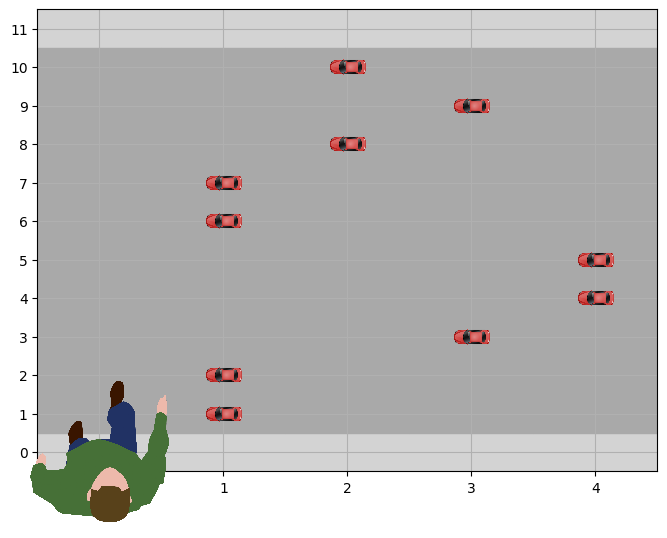

Collision!


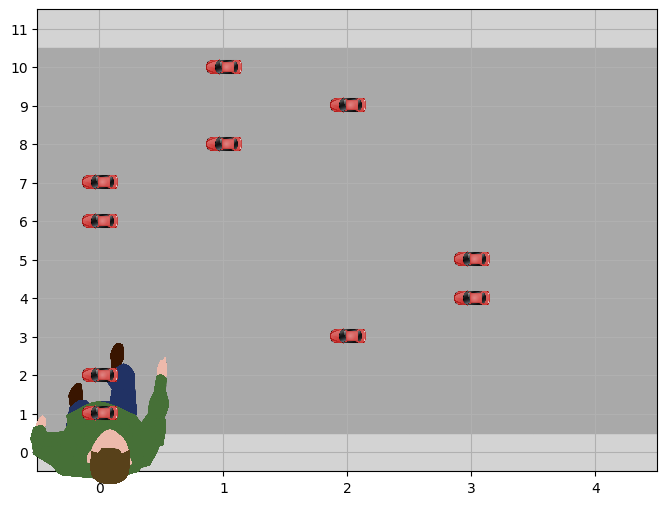

In [31]:
# Evaluación y visualización
obs, _ = env.reset()
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    env.render()  # Visualización de cada paso para pruebas